In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import warnings
import tqdm
from datetime import datetime
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
warnings.filterwarnings('ignore')
import seaborn as sns
import matplotlib.pyplot as plt
import toad
from toad.plot import bin_plot, badrate_plot
import matplotlib
import shap
import random
import pickle
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

train_x = pd.read_csv('./data/train/feature.csv')
train_y = pd.read_csv('./data/train/label.csv')
test_x = pd.read_csv('./data/test/feature.csv')
test_y = pd.read_csv('./data/test/label.csv')

train:  0    71957
1     1543
Name: DEFAULT_LABEL, dtype: int64
test: 0    23986
1      514
Name: DEFAULT_LABEL, dtype: int64


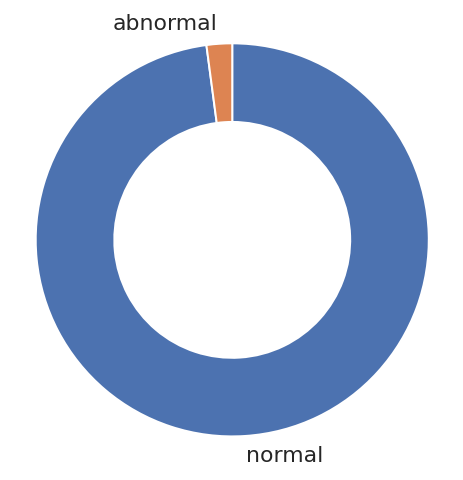

In [2]:
train_ = pd.merge(train_x,train_y,on='APPLICATION_ID')
test = pd.merge(test_x,test_y,on='APPLICATION_ID')

del train_['APPLICATION_DATE']
del test['APPLICATION_DATE']
train_ = train_.iloc[:,:len(train_.columns)]
test = test.iloc[:,:len(test.columns)]
fea = list(set(train_.columns).intersection(set(test.columns)))
train_ = train_[fea]
test = test[fea]
sorted_counts = train_['DEFAULT_LABEL'].value_counts()
print('train: ',sorted_counts)
print('test:',test['DEFAULT_LABEL'].value_counts())
plt.pie(sorted_counts, labels = ['normal','abnormal'], startangle = 90,
        counterclock = False, wedgeprops = {'width' : 0.4});
plt.axis('square')
plt.savefig('./image/label_distribution.pdf', dpi=500, bbox_inches='tight')
fea_describe = train_.describe() 
fea_describe.to_csv('fea_describe.csv')

In [3]:
# 查看缺失率大于0.5的特征
train = train_.copy()
have_null_fea_dict = (train.isnull().sum()/len(train)).to_dict()
fea_null_moreThanHalf = {}
for key,value in have_null_fea_dict.items():
    if value > 0.5:
        fea_null_moreThanHalf[key] = value
        
train_fea_ = list(set(train.columns).difference(set(list(fea_null_moreThanHalf.keys()))))
df_train = train[train_fea_]
df_test = test[train_fea_]
print(df_train.shape,df_test.shape)

# 缺失值填充
for column in list(df_train.columns[df_train.isnull().sum() > 0]):
    mean_val = df_train[column].mean()
    df_train[column].fillna(mean_val, inplace=True)
for column in list(df_test.columns[df_test.isnull().sum() > 0]):
    mean_val = df_test[column].mean()
    df_test[column].fillna(mean_val, inplace=True)
print(df_train.shape,df_test.shape)

# 删除全0特征
list_all_0 = ['v669','v424','v304']
train_fea_ = list(set(train_fea_).difference(set(list_all_0)))


(73500, 507) (24500, 507)
(73500, 507) (24500, 507)


'\n# 训练和测试的特征分布 判断训练与测试分布是否匹配\nt = pd.melt(df_test,value_vars=train_fea_[:8])\ng2 = sns.FacetGrid(t,col="variable",col_wrap=4,sharex=False,sharey=False)\ng2 = g2.map(sns.distplot,"value")\nori_colnum_2 = df_test.shape[1]\ng2.savefig(\'./image/test_fea_dis.pdf\', dpi=500, bbox_inches=\'tight\')\n'

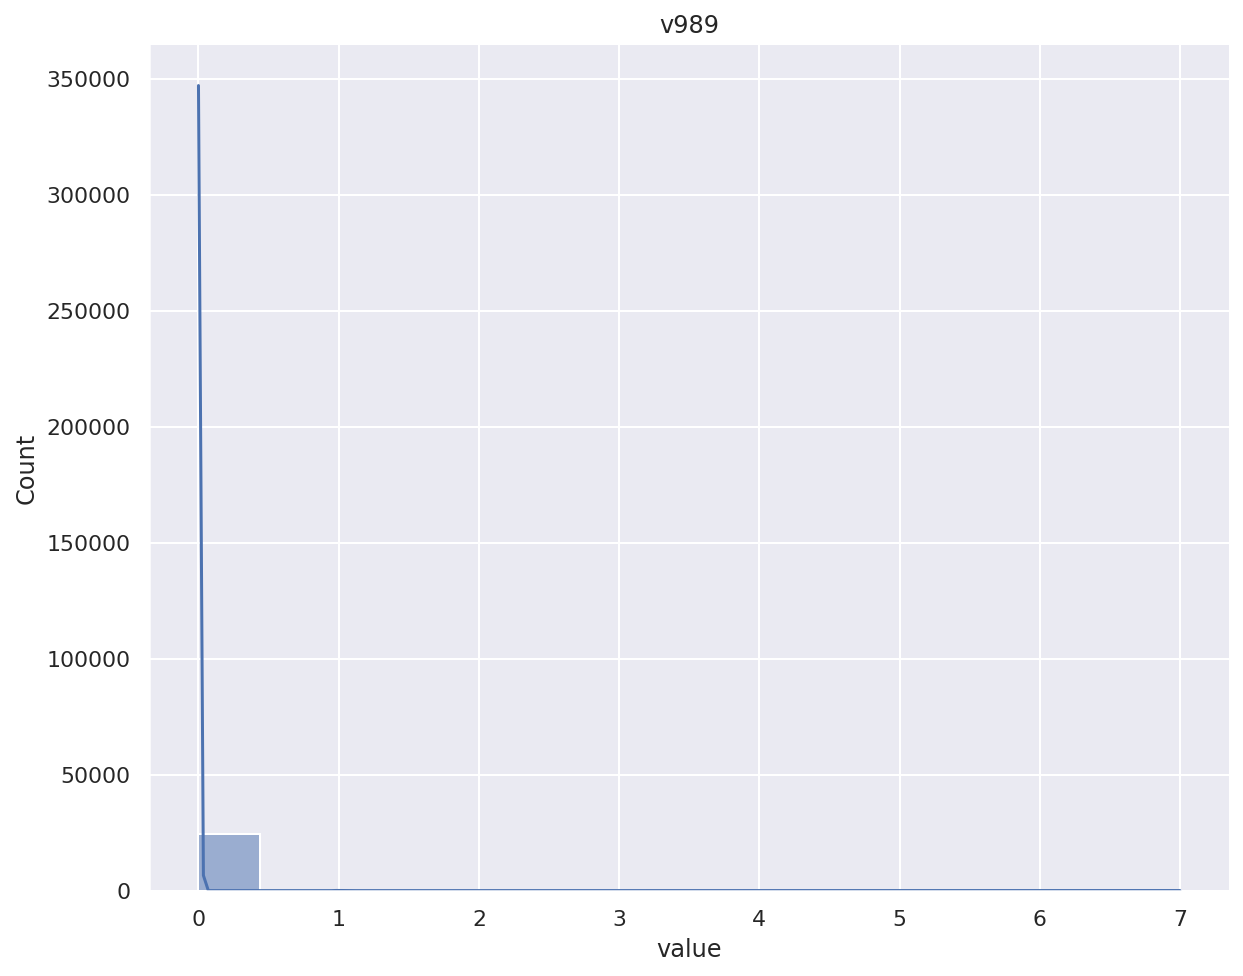

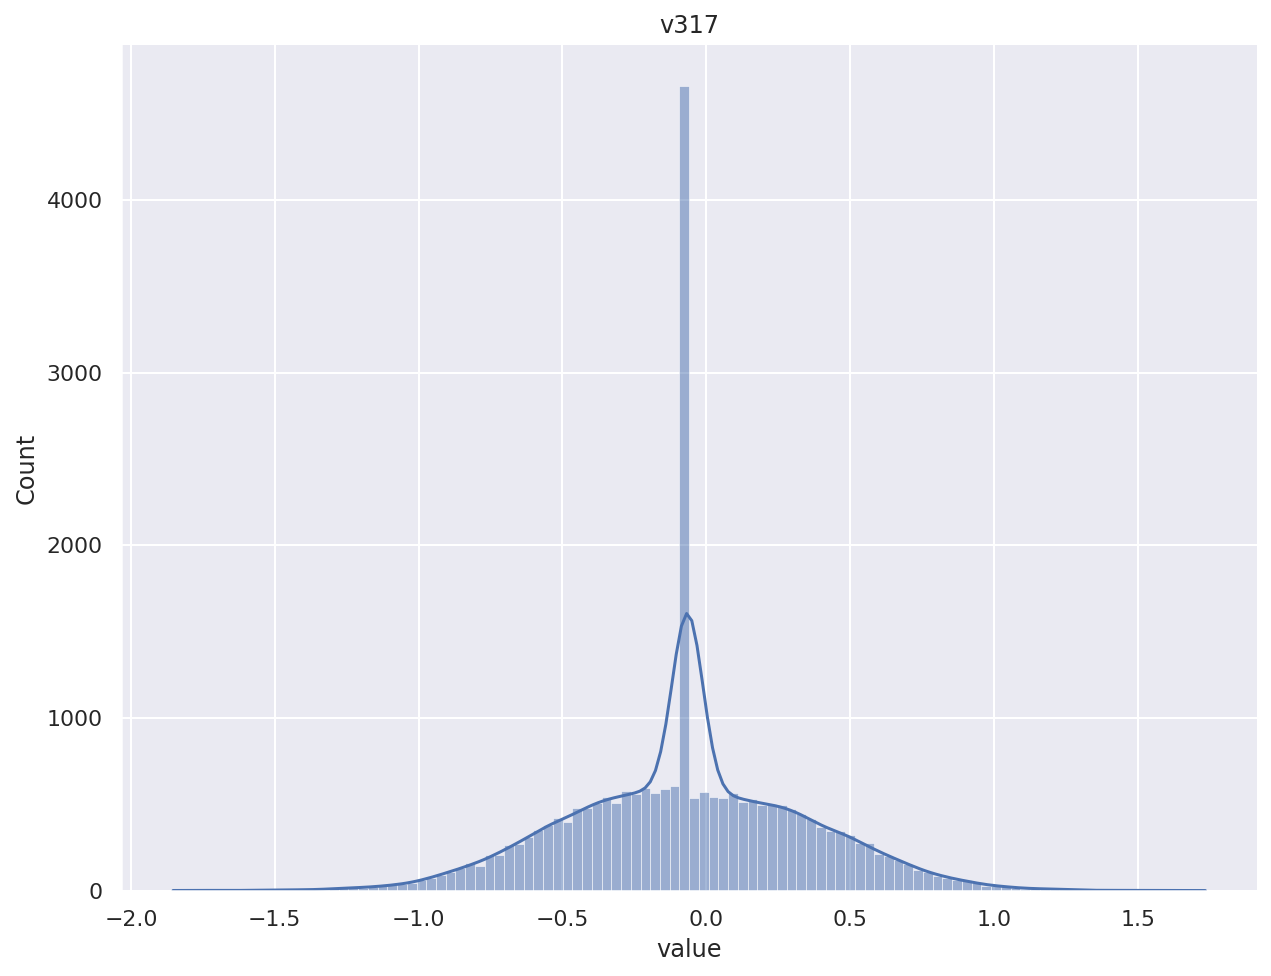

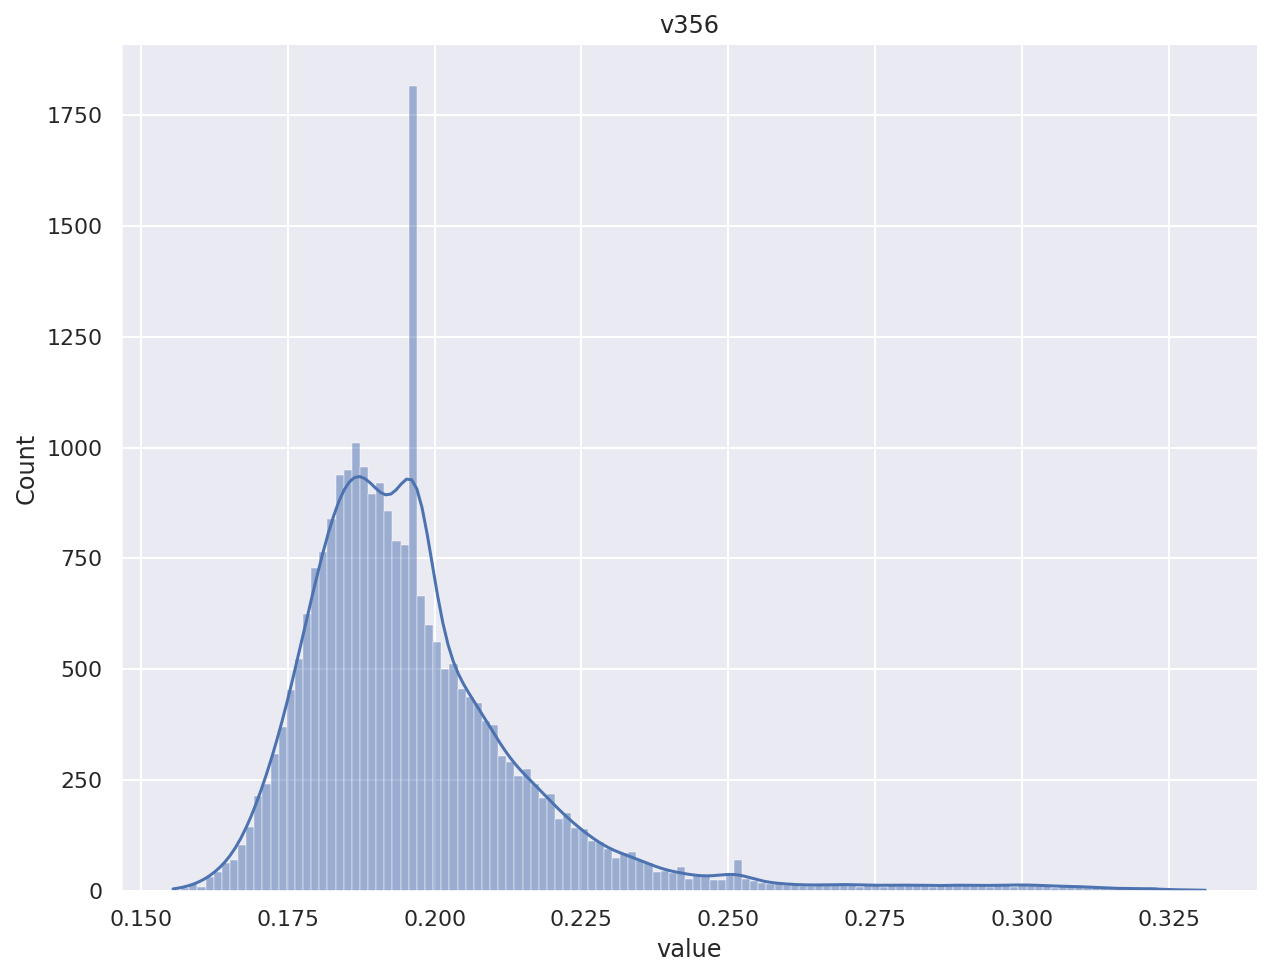

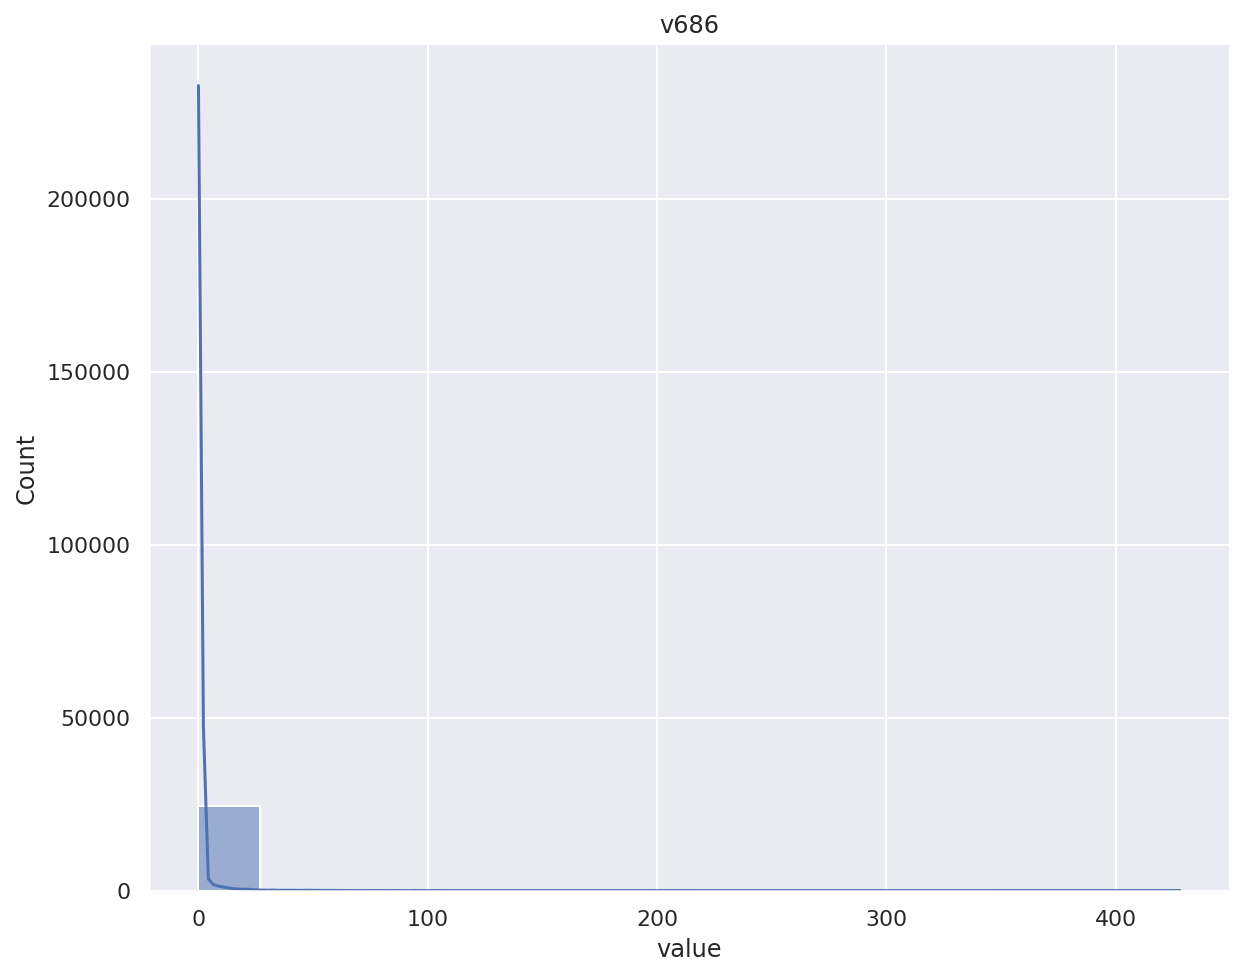

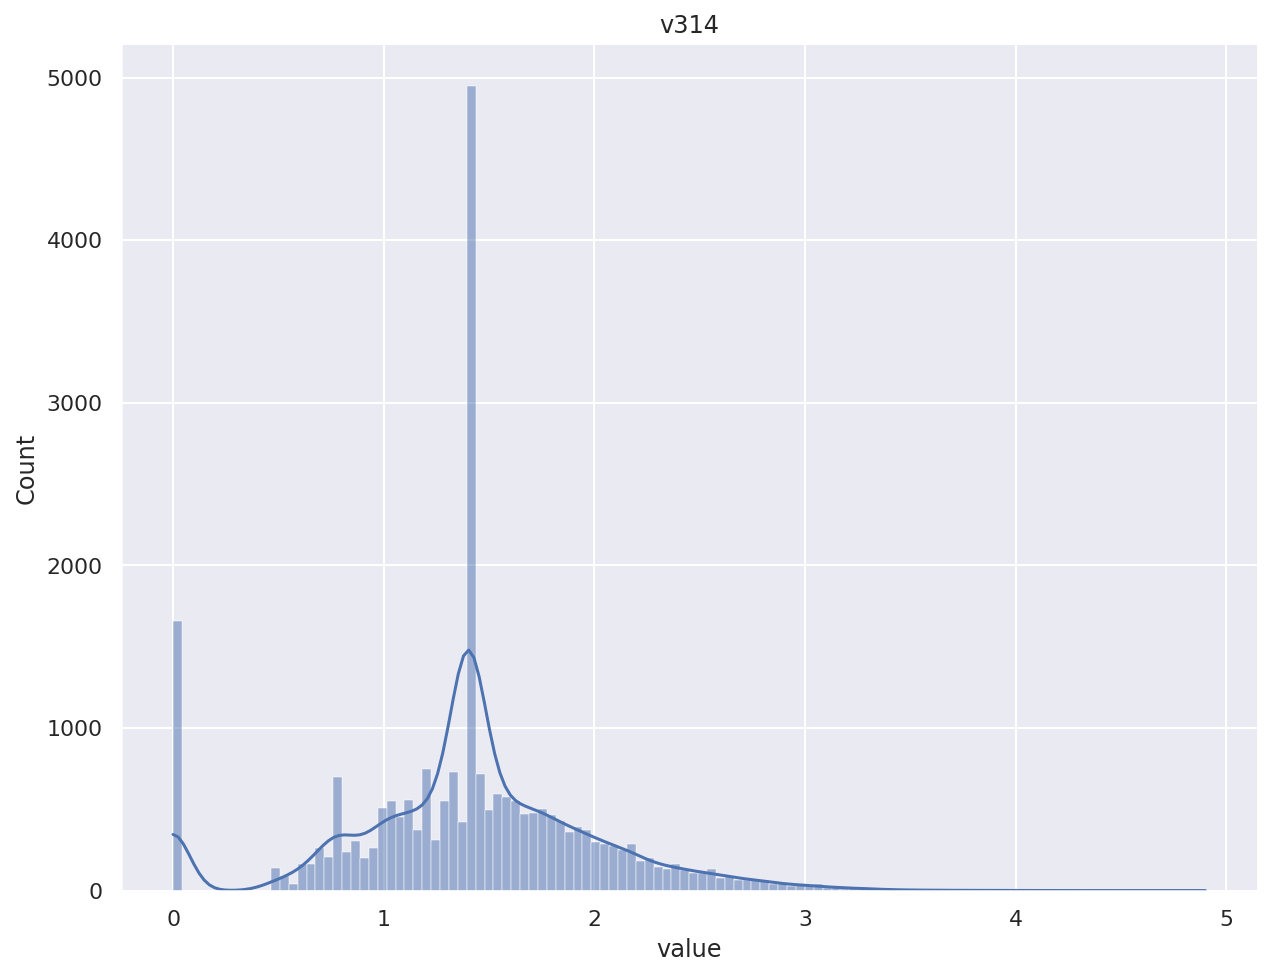

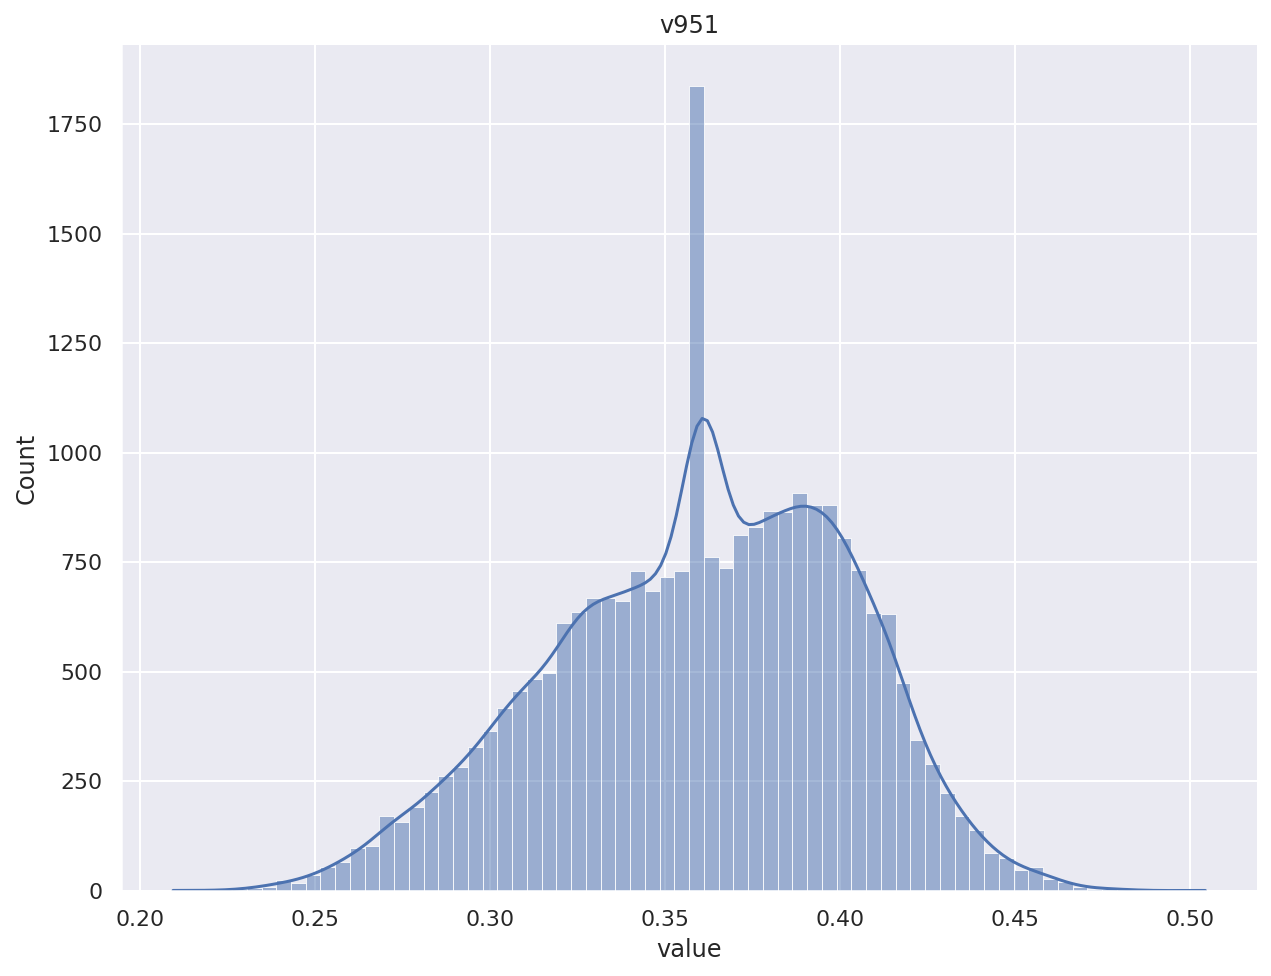

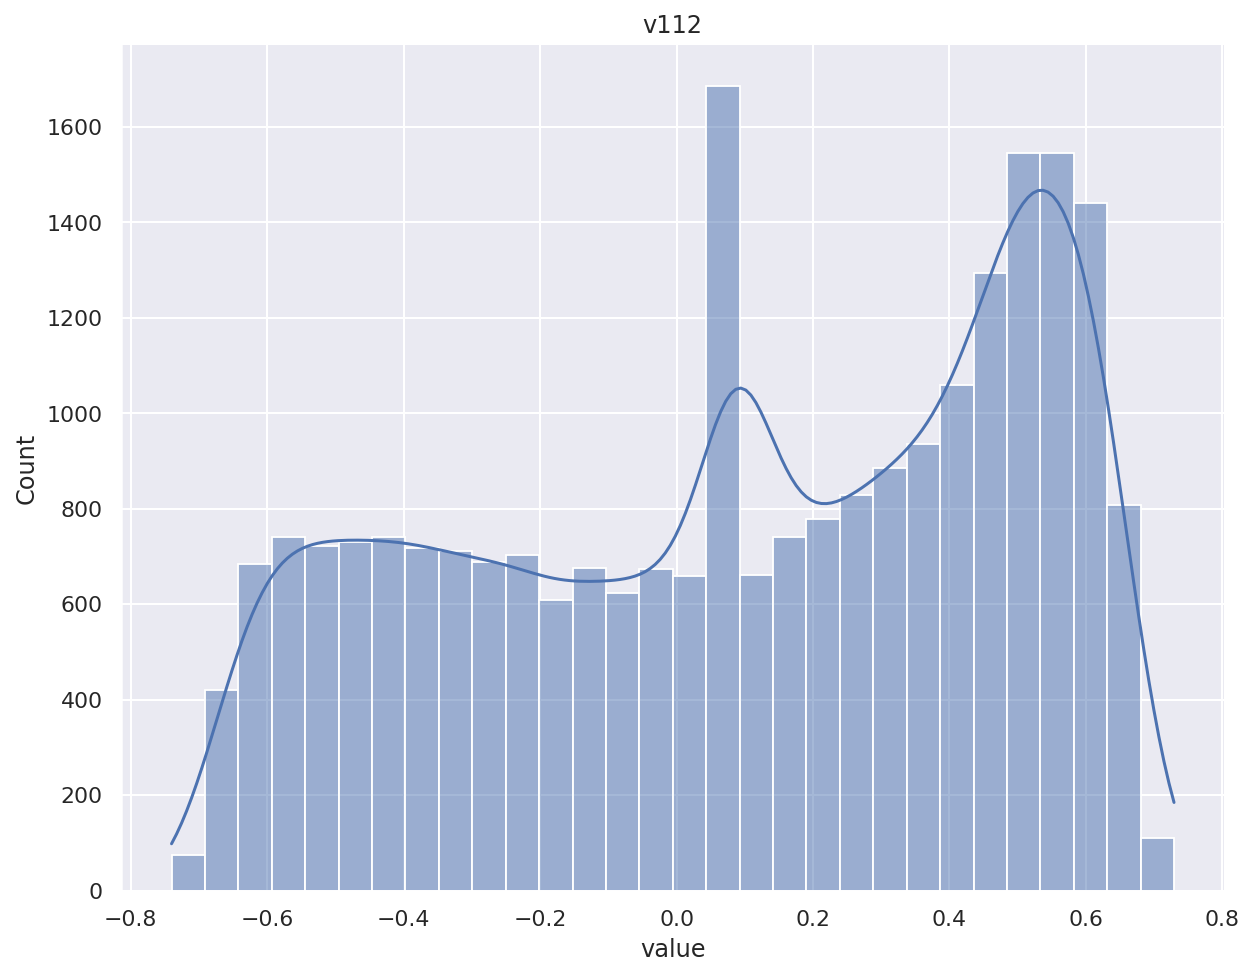

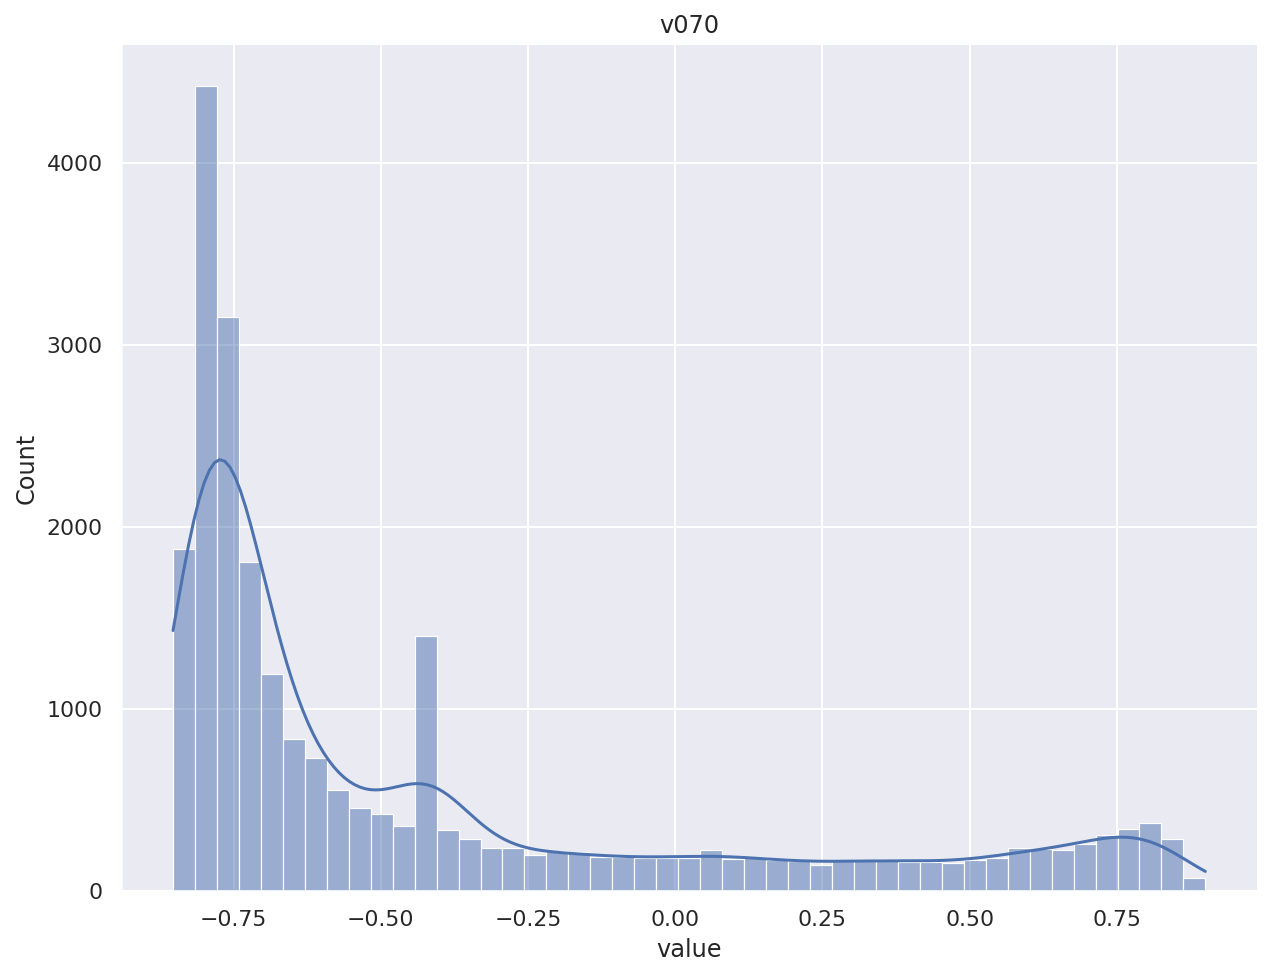

In [4]:
for fea_name in train_fea_[10:18]:
# fea_name = train_fea_[4]
    f = pd.melt(df_test,value_vars=fea_name)
    sns.set_style("darkgrid")
    p = sns.displot(data=f, x="value", kde=True)
    p.fig.set_size_inches(10,7)
    plt.title('{}'.format(fea_name))  
    # g1 = sns.FacetGrid(f,col="variable",col_wrap=4,sharex=False,sharey=False)
    # g1 = g1.map(sns.distplot,"value")
    # ori_colnum_1 = df_train.shape[1]
    p.savefig('./image/train_fea{}_dis.pdf'.format(fea_name), dpi=500, bbox_inches='tight')

'''
# 训练和测试的特征分布 判断训练与测试分布是否匹配
t = pd.melt(df_test,value_vars=train_fea_[:8])
g2 = sns.FacetGrid(t,col="variable",col_wrap=4,sharex=False,sharey=False)
g2 = g2.map(sns.distplot,"value")
ori_colnum_2 = df_test.shape[1]
g2.savefig('./image/test_fea_dis.pdf', dpi=500, bbox_inches='tight')
'''

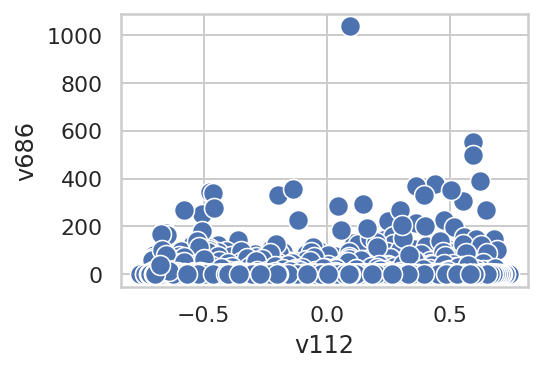

In [25]:

# 特征pairplot
# fea = list(set(train_fea_).difference(set(['APPLICATION_ID','DEFAULT_LABEL'])))[:5]
# fea.append('DEFAULT_LABEL')
# fig = sns.pairplot(df_train[fea].iloc[:1000,:],hue="DEFAULT_LABEL")
# fig.savefig('./image/train_fea_dis_top100.pdf', dpi=500, bbox_inches='tight')


# 单个特征散点图
fea = list(set(train_fea_).difference(set(['APPLICATION_ID','DEFAULT_LABEL'])))[:20]
plt.figure(figsize=(3.64, 2.51))
fig = sns.scatterplot(x = df_train[fea[16]], y = df_train[fea[13]],data = df_train[[fea[1],fea[13]]], palette = 'Set1', s = 100)
scatter_fig = fig.get_figure()
scatter_fig.savefig('./plot/fea_{}.png'.format(16), dpi=500, bbox_inches='tight')


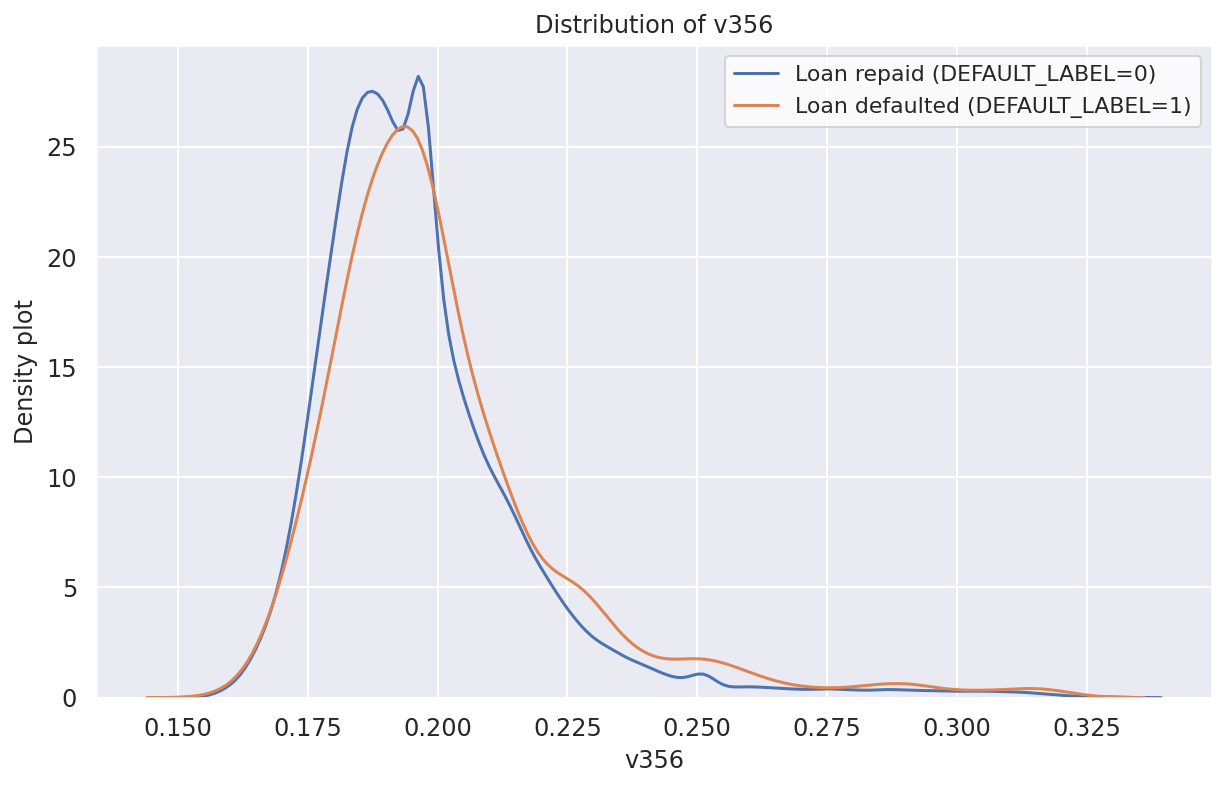

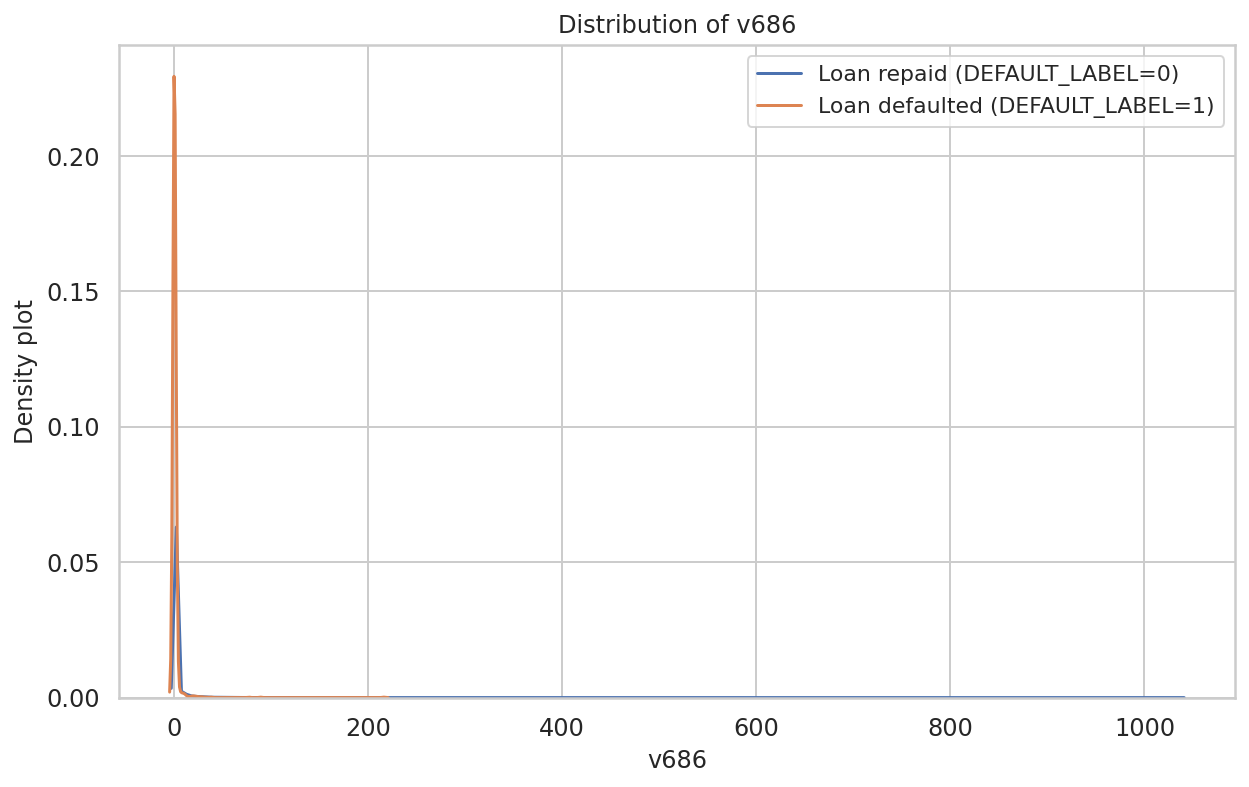

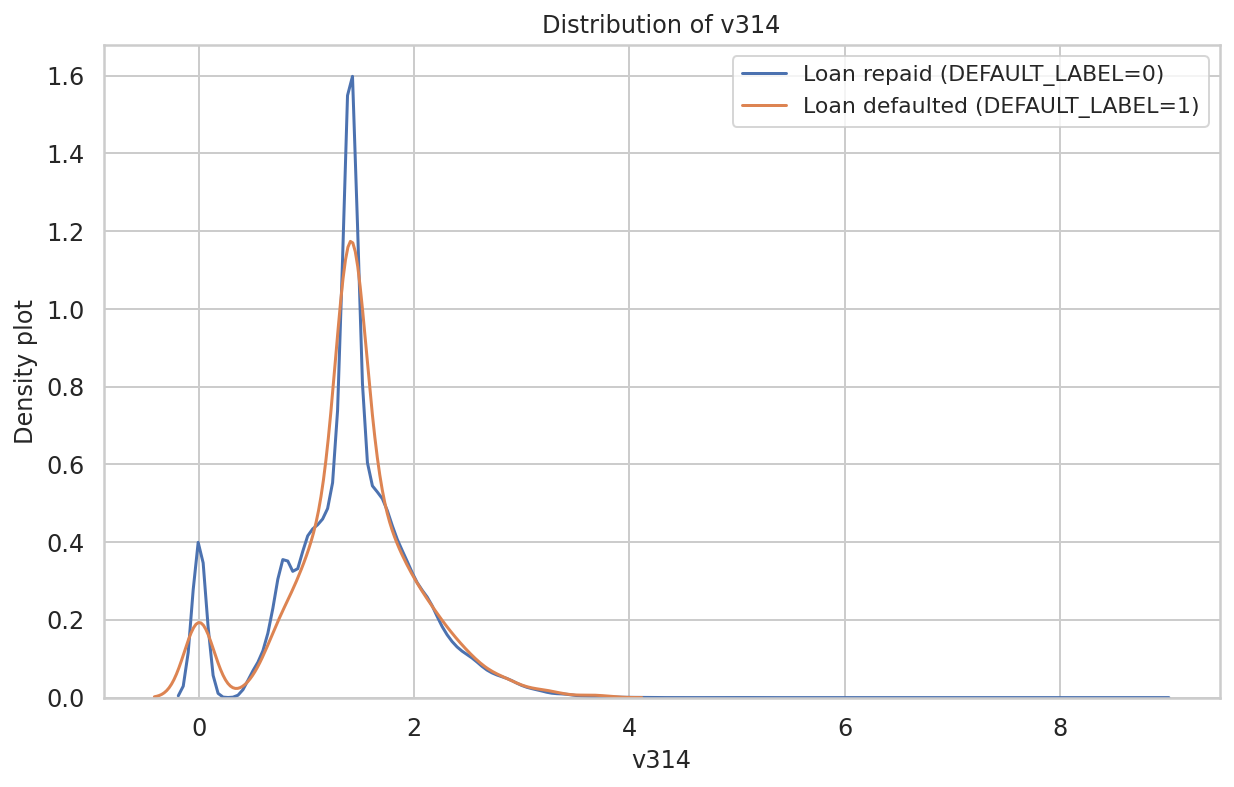

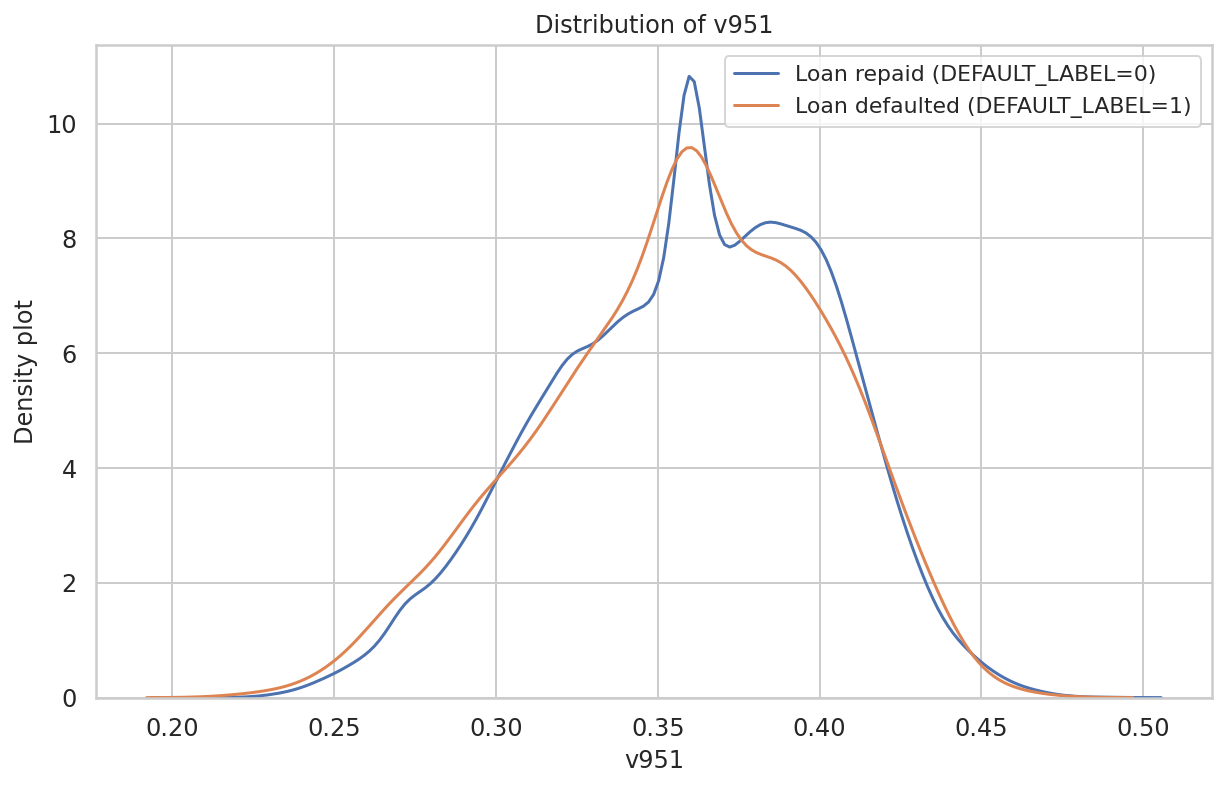

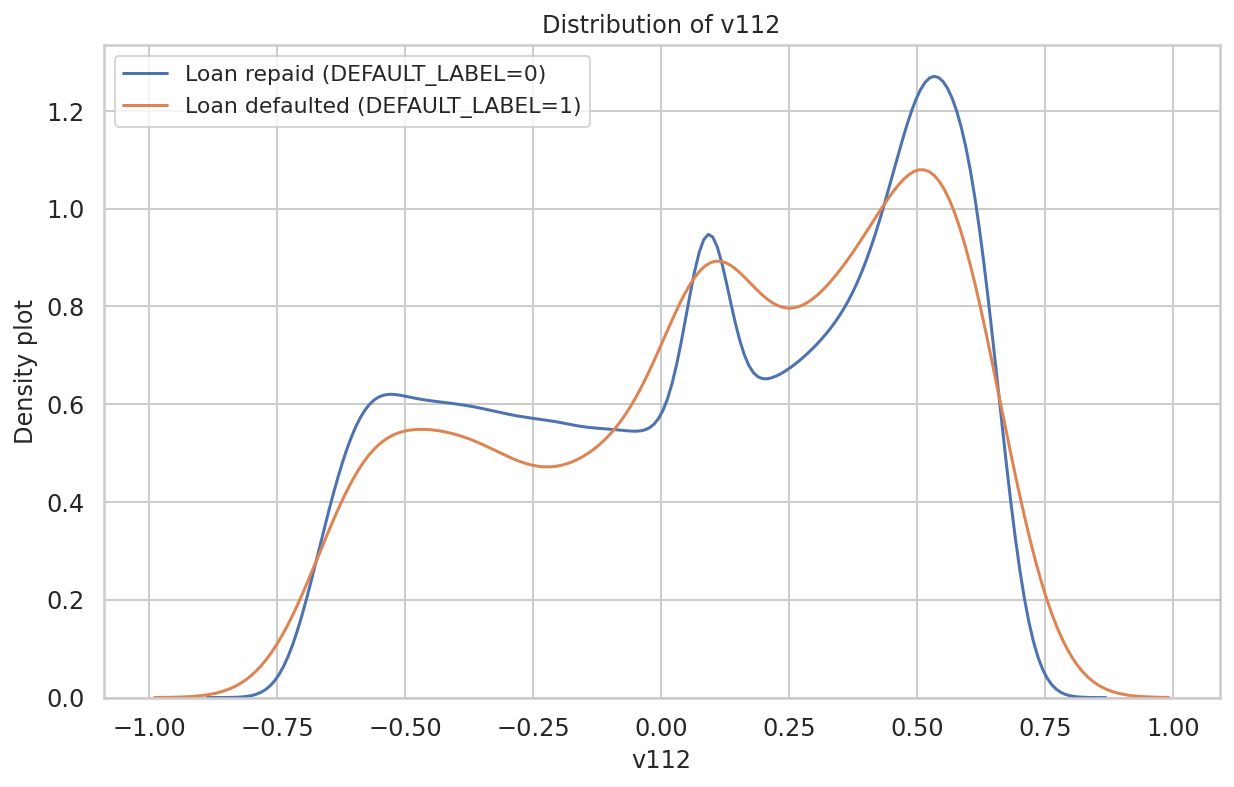

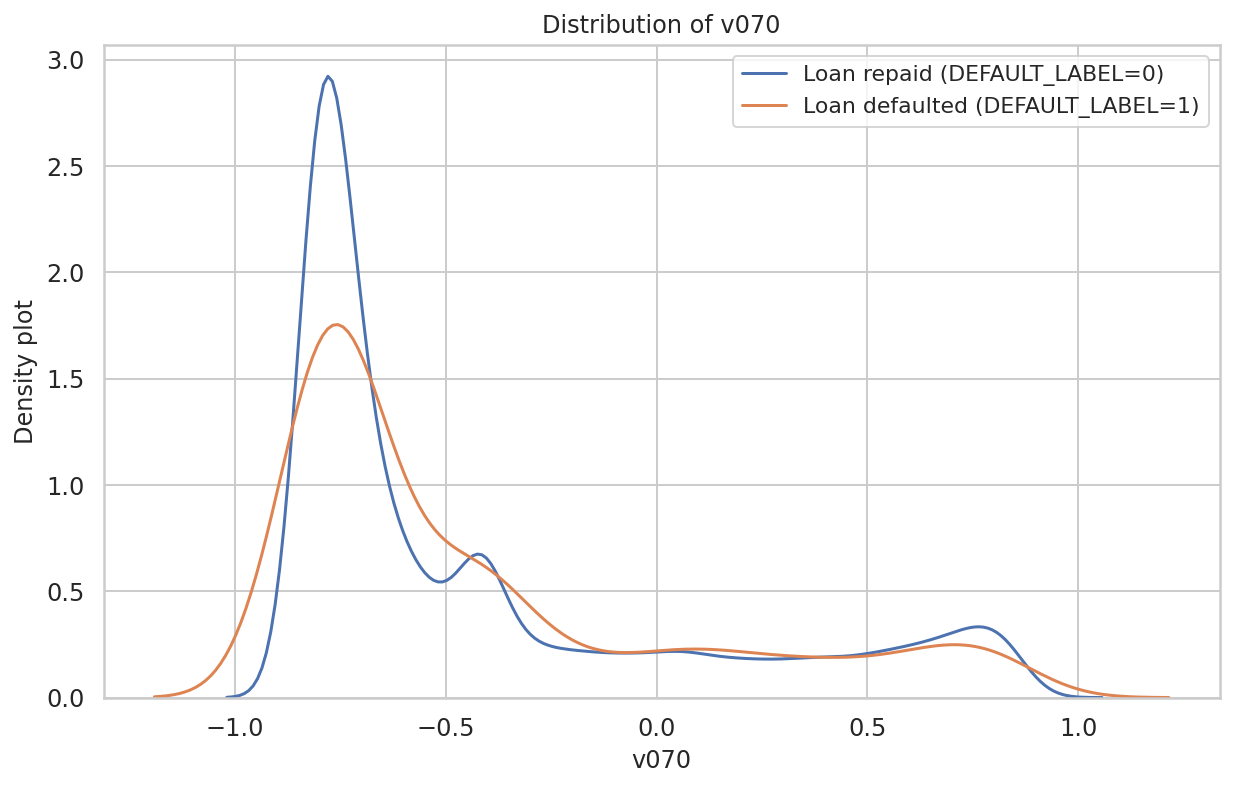

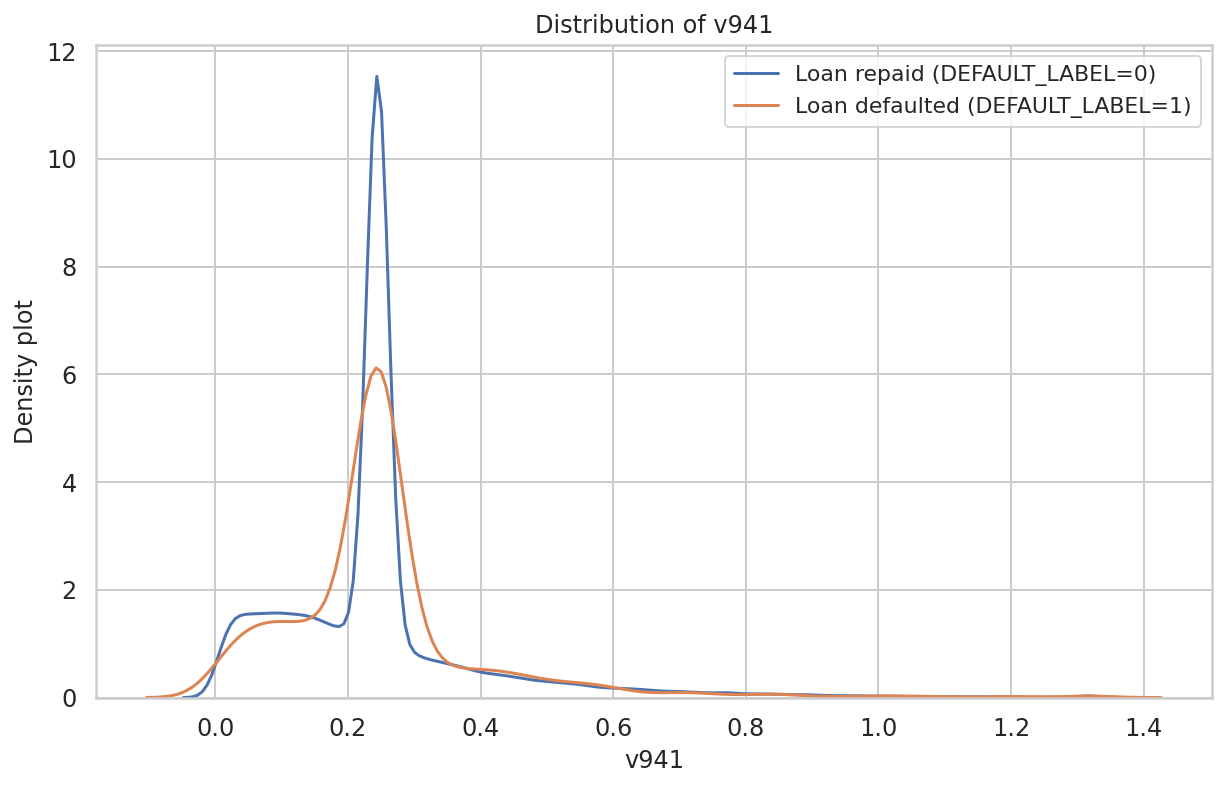

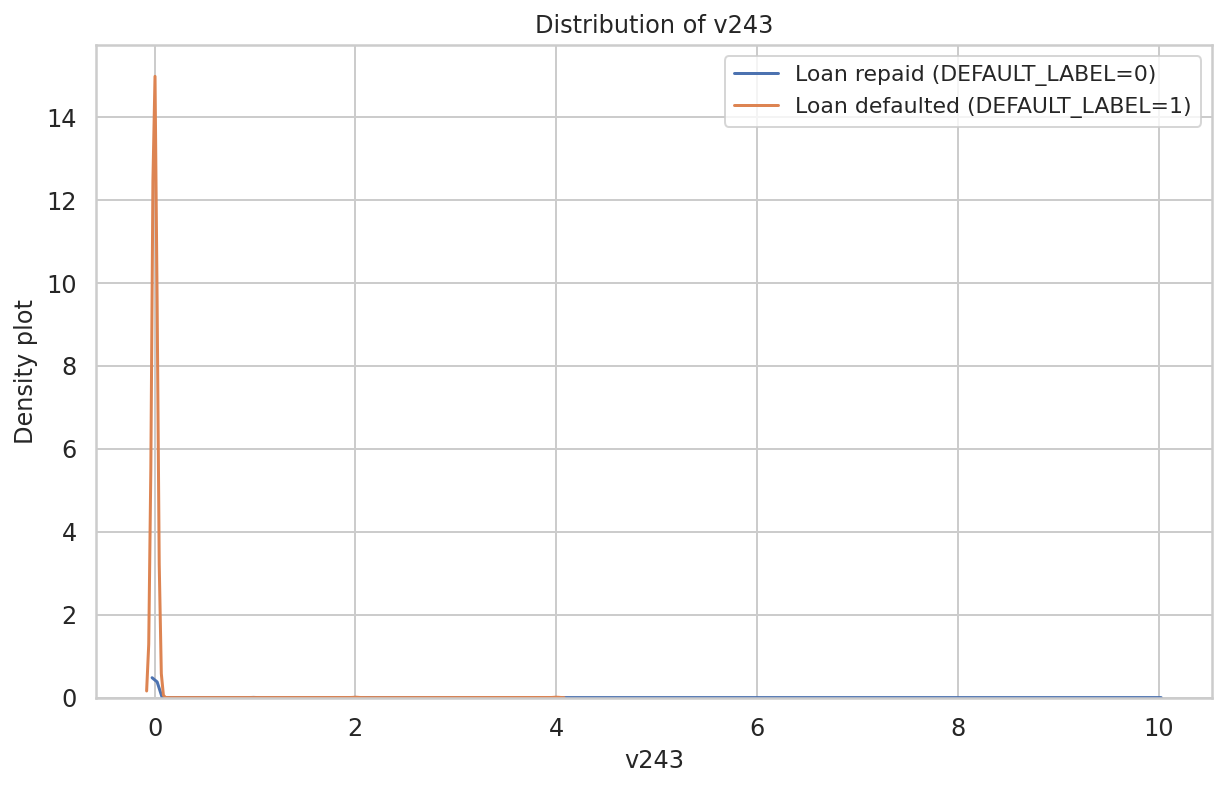

In [6]:
# 不同特征与标签之前的关系
def plot_distribution_gen(feature,df=None,separate_target=False):
    if df is None:
        df = df_train
    else:
        df = df
        
    if separate_target == False:
        plt.figure(figsize=(10,6))
        plt.title("Distribution of %s" % feature)
        sns.distplot(df[feature].dropna(),color='red', kde=True,bins=100)
    else:
        t1 = df.loc[df['DEFAULT_LABEL'] != 0]
        t0 = df.loc[df['DEFAULT_LABEL'] == 0]
        
        plt.figure(figsize=(10,6))
        plt.title("Distribution of %s" % feature)
        sns.set_style('whitegrid')
#         sns.kdeplot(t1[feature], bw=0.5,label="Loan defaulted (TARGET=1)")
#         sns.kdeplot(t0[feature], bw=0.5,label="Loan repaid (TARGET = 0)")
        
        sns.kdeplot(df.loc[df['DEFAULT_LABEL'] == 0, feature], label = 'target == 0')
        sns.kdeplot(df.loc[df['DEFAULT_LABEL'] == 1, feature], label = 'target == 1')
    
        plt.ylabel('Density plot', fontsize=12)
        plt.xlabel(feature, fontsize=12)
        plt.legend(loc="best", labels=['Loan repaid (DEFAULT_LABEL=0)', 'Loan defaulted (DEFAULT_LABEL=1)'])
        locs, labels = plt.xticks()
        plt.tick_params(axis='both', which='major', labelsize=12)
#     plt.show();
    plt.savefig('./image/fea{}_corr_label.pdf'.format(feature), dpi=500, bbox_inches='tight')
    
for fea_name in train_fea_[12:20]:
    plot_distribution_gen(fea_name,None,True)

In [ ]:
# 特征IV筛选
iv_info = toad.quality(df_train[set(train_fea_).difference(set(['APPLICATION_ID']))],'DEFAULT_LABEL', iv_only=True)
eff = iv_info.loc[iv_info['iv'] >=0.02]

sns.barplot(data=eff[:20],x=eff.index[:20],y='iv')
plt.rcParams['figure.figsize']=(20,5)
plt.xticks(rotation=270)
plt.title('iv of partial features')
plt.grid(b=False)  
plt.savefig('./image/fea_iv.pdf', dpi=500, bbox_inches='tight')

In [ ]:
# 部分特征相似度
fea = list(set(train_fea_).difference(set(['APPLICATION_ID'])))[:15]
df_corr_min = df_train[fea].iloc[:200,:].corr()
fig, ax = plt.subplots()
fig.set_size_inches(15, 10)
corr = sns.heatmap(df_corr_min, cmap='PuBu',ax=ax,annot=True,linewidths=2)
fig.savefig('./image/fea_corr.pdf', dpi=500, bbox_inches='tight')